In [1]:
import pandas as pd
import numpy as np
from dotenv import dotenv_values, find_dotenv
import matplotlib.pyplot as plt
import os
config = dotenv_values(find_dotenv())
path_cleandata = os.path.abspath(config["CLEANDATA"]) + '\\'
path_figures = os.path.abspath(config["FIGURES"]) + '\\'

In [2]:
# import my merged data
data = pd.read_pickle(path_cleandata + 'BEA6_naics6_merged.pkl')

In [3]:
# filter for the year 2017 
data2017 = data[data['date'].dt.year == 2017]

In [4]:
# personal consumption expenditures
data2017 = data2017[data2017['product_O'].str.contains('Personal consumption expenditures')][['product_I', 'date', 'IO_value', 'expenditures_I']]

In [5]:
# sum by product for that year
# first groupby: take sum of IO_value and mean of expenditures_I by date and product
byproduct = data2017.groupby(['product_I']).agg({
    'IO_value': 'mean',
    'expenditures_I': 'mean'}, min_count=1).reset_index()


In [6]:
byproduct.set_index('product_I')[['IO_value', 'expenditures_I']].sum(axis=0)

IO_value          11362488.0
expenditures_I    13578616.0
dtype: float64

## taking a look at how well the merge worked

In [8]:
# create distance variable
byproduct['distance'] = np.abs(byproduct['IO_value'] - byproduct['expenditures_I'])

# kinda "outliers" that have a very different value
outlier_threshold = 100000

# Filter only the points that are outliers
outliers = byproduct[byproduct['distance'] > outlier_threshold]

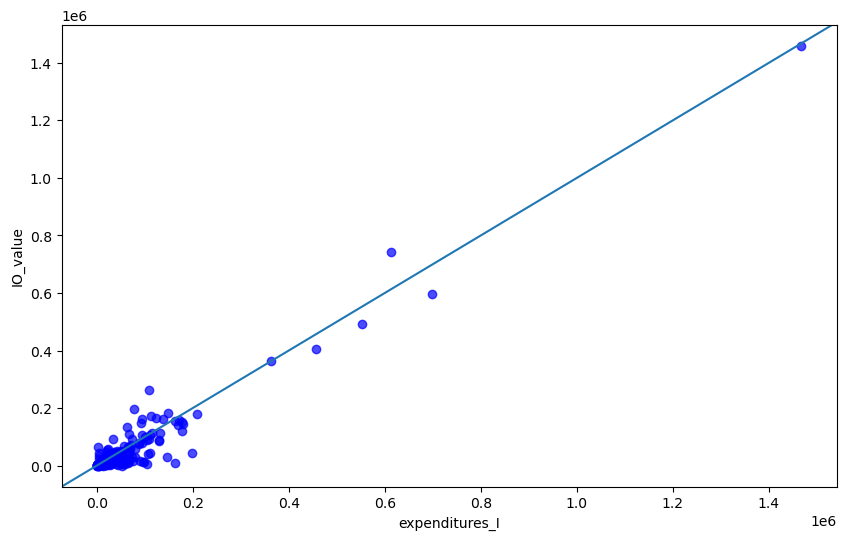

In [9]:
# do the scatter plot with expenditures on the x axis

plt.figure(figsize=(10, 6))
plt.scatter(byproduct['expenditures_I'], byproduct['IO_value'], c='blue', alpha=0.7)

plt.xlabel('expenditures_I')
plt.ylabel('IO_value')

ax = plt.gca()
ax.axline((0, 0), slope=1)

plt.savefig(path_figures + 'merge_check\\expenditures.pdf')

In [10]:
# this is the list of "outlier" products: issues mostly come from housing and healthcare type stuff
# noting the 2017 expenditures for tenant-occupied stationary houses is 0: having trouble getting min_count to work (actually all NaNs)
# within the merge, foreign travel in the United States gets matched with the rest-of-world adjustment in the IO table, which i should probably get rid of
outliers

,product_I,IO_value,expenditures_I,distance
37,"Education services, gross output",42077.272514,198067.25,155989.977486
51,"Food products, not elsewhere classified",10259.041070,161953.75,151694.708930
111,Net motor vehicle and other transportation ins...,195327.298423,77603.00,117724.298423
121,"Nonprofit hospitals, gross output",596968.330989,698362.00,101393.669011
130,Other purchased meals,741311.351550,611960.75,129350.601550
161,Proprietary and public higher education,261107.082032,107830.00,153277.082032
179,Specialty outpatient care facilities and healt...,29419.000000,146815.00,117396.000000


In [11]:
# go into concordance, which shows some of the issues

concordance = pd.read_pickle(path_cleandata + 'concordance//concordance6_naics6_addproportions.pkl')
outlierproducts = list(outliers['product_I'])

outliermerges = concordance[concordance['product'].isin(outlierproducts)]
outliermerges

,product,NAICS_desc,IO_proportions
75,Net motor vehicle and other transportation ins...,Direct life insurance carriers,0.783770
76,Net motor vehicle and other transportation ins...,"Insurance carriers, except direct life",0.404028
104,"Food products, not elsewhere classified",Snack food manufacturing,0.209266
105,"Food products, not elsewhere classified",Food and beverage stores,0.165355
202,"Nonprofit hospitals, gross output",Hospitals,0.574452
203,"Nonprofit hospitals, gross output",State and local government (hospitals and heal...,0.810343
216,"Education services, gross output",Other educational services,0.600490
217,"Education services, gross output",State and local government (educational services),0.547880
218,"Education services, gross output",Employment services,0.510534
308,Other purchased meals,All other food and drinking places,0.728404


c:\Users\EmilyFu\.conda\envs\myenv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


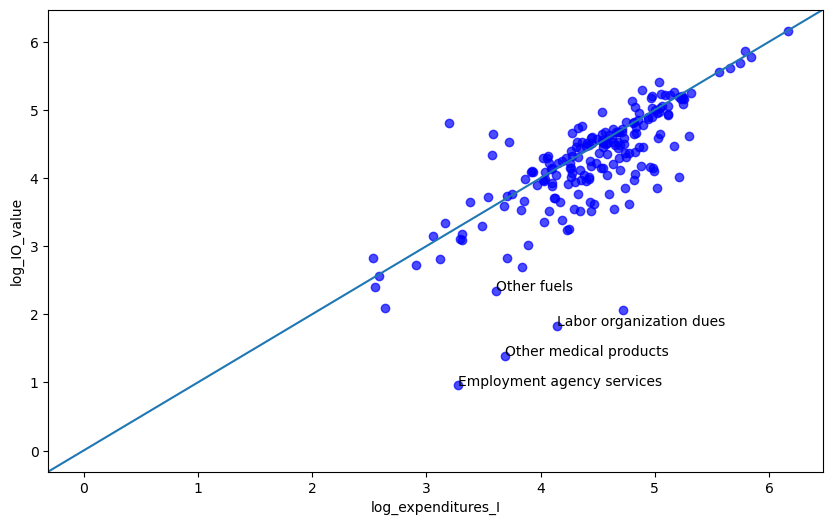

In [23]:
# get logs of everything and do an equivalent scatter plot with those

# do the scatter plot with expenditures on the x axis 
# do a base 10 log
plt.figure(figsize=(10, 6))
plt.scatter(np.log10(byproduct['expenditures_I']), np.log10(byproduct['IO_value']), c='blue', alpha=0.7)

plt.xlabel('log_expenditures_I')
plt.ylabel('log_IO_value')

ax = plt.gca()
ax.axline((0, 0), slope=1)


for idx, row in byproduct.iterrows():
    if byproduct['product_I'][idx] in ['Employment agency services', 'Other medical products', 'Labor organization dues', 'Processed dairy producrs', 'Other fuels']:
        plt.annotate(byproduct['product_I'][idx], (np.log10(byproduct['expenditures_I'])[idx], np.log10(byproduct['IO_value'])[idx]))

plt.savefig(path_figures + 'merge_check\\log_expenditures.pdf')


